# China/PLP trocas comerciais

A partir dos dados da base comtrade das Nações Unidas

## Criar ficheiro de configuração se não existir

O ficheiro de configuração serve para armazenar
a APIKEY que dá acesso a mais de 500 linhas de
resultados.


In [1]:
import os

fname = 'config.ini'
content = """
# Ficheiro de configuração
[comtrade]
# Add API Key. DO NOT SHARE
key = APIKEYHERE
"""
if not os.path.isfile(fname):
  print("Criando ficheiro de configuração")
  with open(fname,'w') as f:
    f.write(content)


## Obter uma chave de acesso à API

Para aceder à UN Comtrade via API sem limites é necessário uma chave de acesso,
de outro modo os resultados são limitados a 500 linhas.

Para obter a chave de acsso:
* Registo em https://comtradedeveloper.un.org/
* Ir para _Products_ 
* Selecionar "Premium Individual APIs" (https://comtradedeveloper.un.org/product#product=dataapis)
* Escolher _Subscribe to "comtrade - v1"_  
* Esperar pelo email com a chave da API key (demora alguns dias
* Copia a chave para o local indicado no ficheiro `config.ini` antes
  de executar o resto do notebook.


In [2]:
import comtrade
import configparser

if os.path.isfile(fname):

    config = configparser.ConfigParser()
    config.read('config.ini')
    APIKEY = config['comtrade']['key']

comtrade.init(APIKEY)

## Parâmetros gerais que não mudam



In [3]:
from comtrade import COUNTRY_CODES_REVERSE as m49

In [4]:
m49_angola = m49['Angola']
m49_brazil = m49['Brazil']
m49_cabo_verde = m49['Cape Verde']
m49_china = m49['China']
m49_hong_kong = m49['China Hong Kong']
m49_macau = m49['China Macau']
m49_guine_equatorial = m49['Equatorial Guinea']
m49_guine_bissau = m49['Guinea-Bissau']
m49_mozambique = m49['Mozambique']
m49_portugal = m49['Portugal']
m49_stome_principe = m49['Sao Tome and Principe']
m49_timor = m49['Timor-Leste']

# make list of Portuguese Speaking Countries
m49_plp = [m49_angola,m49_brazil,m49_cabo_verde,m49_guine_bissau,
            m49_guine_equatorial,m49_mozambique,m49_portugal,
            m49_stome_principe,m49_timor]
m49_plp_list = ",".join(map(str,m49_plp))




## Parâmetros para visualização

Definir as colunas a visualizar, ordem das linhas abaixo para simplificar
posterior visualização dos dados.

### Descrição das colunas 

In [5]:
import comtrade

print(comtrade.COLS_DESC_DF[['Description']].to_markdown())


| COMTRADE+ DATA ITEMS     | Description                                                                              |
|:-------------------------|:-----------------------------------------------------------------------------------------|
| datasetCode              | Combination of several keys to identify specific datasetCode                             |
| typeCode                 | Product type: Goods or Services                                                          |
| freqCode                 | The time interval at which observations occur                                            |
| refPeriodId              | The period of time to which the measured observation is intended to refer                |
| refYear                  | Year of observation                                                                      |
| refMonth                 | Month of observation. For annual, it would bet set to 52                                 |
| period                   | Combination

TODO: isto podia ir para o módulo

In [6]:
cols_all = list(comtrade.COLS_DESC.keys())
cols_basic = ['reporterCode','reporterDesc',
              'partnerCode','partnerDesc',  
              'partner2Code','partner2Desc',  
              'period','flowCode','flowDesc',
              'primaryValue']
sort_order = ['reporterDesc','partnerDesc','period']

## Cobertura dos dados: importações/exportações China-PLP anos disponíveis

In [7]:
import time
import pandas as pd
import comtrade


comtrade.init(APIKEY)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 500)

flow = "M,X"

period = comtrade.year_range()
for country_code in m49_plp:
    df = comtrade.get_data("C",# C for commodities, S for Services
                     "A",# (freqCode) A for annual and M for monthly
                     flowCode=flow,
                     reporterCode=m49_china,
                     partnerCode=country_code,
                     partner2Code=0,
                     period=period, # period None returns all the available period
                     apiKey=APIKEY,
                     timeout=30,
                     echo_url=False
                     )
    print(f"{comtrade.COUNTRY_CODES[country_code]},  {df.refYear.unique().min()}-{df.refYear.unique().max()}")
    time.sleep(0.5)  # avoid stressing the UN server.


Angola,  1992-2021
Brazil,  1992-2021
Cape Verde,  1992-2021
Guinea-Bissau,  1992-2021
Equatorial Guinea,  1992-2021
Mozambique,  1992-2021
Portugal,  1992-2021
Sao Tome and Principe,  1992-2021
Timor-Leste,  2003-2021


## Directoria para relatórios e gráficos

In [8]:
from pathlib import Path

report_dir = 'reports'
Path(report_dir).mkdir(parents=True, exist_ok=True)

## China e PLP: importações, exportações, volume, saldos

O Forum Macau inclui desde 2016 um quadro sumário
dos dados das trocas comerciais entre a China e 
os PLP. Ver https://www.forumchinaplp.org.mo/pt/publications-data-4/annual-reports/

Esses quadros fornecem o valor das exportações e importação e o 
volume de trocas (importações + exportações). Não calculam o saldo.

Aqui reproduzimos esses quadros a partir das
informações atualmente disponíveis no UN Comtrade,
para todo os anos para os quais existem dados, incluindo o saldo.

>NOTA: Tal como nos quadros do Forum os valores são
apresentados em 10 mil USD

In [9]:
import comtrade


pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 500)
pd.options.display.float_format = '{:,.2f} $10mil'.format

year_start = 1984
year_end = 2026
period = comtrade.year_range(year_start,year_end)
flow = "M,X"
partnerCode = m49_plp_list
df = comtrade.get_data("C",# C for commodities, S for Services
                     "A",# (freqCode) A for annual and M for monthly
                     flowCode=flow,
                     reporterCode=m49_china,
                     partnerCode=partnerCode,
                     cmdCode='TOTAL',
                     period=period,
                     apiKey=APIKEY,
                     timeout=30
                     )

temp=df.pivot(index=['refYear','partnerDesc',],columns='flowCode',values='primaryValue')
temp['C'] = temp['M'] + temp['X']
temp['S'] = temp['X']-temp['M']
forum_type = temp[['C','X','M','S']]
forum_type.columns=['Trocas','Exportações','Importações','Saldo']
forum_type.div(10000).fillna("-")


Trocas         Exportações  \
refYear partnerDesc                                                      
1992    Angola                     3,788.21 $10mil       847.28 $10mil   
        Brazil                    58,405.38 $10mil     6,475.17 $10mil   
        Cape Verde                               -        16.15 $10mil   
        Equatorial Guinea             26.09 $10mil        18.08 $10mil   
        Guinea-Bissau                            -       240.16 $10mil   
        Mozambique                 5,911.89 $10mil     2,072.90 $10mil   
        Portugal                   6,691.20 $10mil     4,399.26 $10mil   
        Sao Tome and Principe                    -         2.48 $10mil   
1993    Angola                    19,191.74 $10mil     1,120.69 $10mil   
        Brazil                   105,523.37 $10mil    19,216.62 $10mil   
        Cape Verde                               -        75.49 $10mil   
        Equatorial Guinea             66.34 $10mil        63.54 $10mil   
        Guinea-Bissau                376.75 $10mil       271.63 $10mil   
        Mozambique                 2,326.57 $10mil     1,654.82 $10mil   
        Portugal                  11,233.26 $10mil     7,392.87 $10mil   
        Sao Tome and Principe                    -        37.96 $10mil   
1994    Angola                     6,046.63 $10mil     1,248.20 $10mil   
        Brazil                   142,116.82 $10mil    36,239.09 $10mil   
        Cape Verde                               -        42.44 $10mil   
        Equatorial Guinea             68.25 $10mil        58.48 $10mil   
        Guinea-Bissau                491.43 $10mil       400.30 $10mil   
        Mozambique                 1,209.43 $10mil       651.82 $10mil   
        Portugal                   9,006.80 $10mil     7,451.75 $10mil   
        Sao Tome and Principe                    -        16.10 $10mil   
1995    Angola                    15,806.66 $10mil     2,115.93 $10mil   
        Brazil                   199,058.88 $10mil    75,905.87 $10mil   
        Cape Verde                               -        38.03 $10mil   
        Equatorial Guinea          1,496.36 $10mil       233.04 $10mil   
        Guinea-Bissau                109.41 $10mil       109.09 $10mil   
        Mozambique                 1,261.61 $10mil     1,152.31 $10mil   
        Portugal                  14,468.75 $10mil    10,605.39 $10mil   
        Sao Tome and Principe                    -        21.32 $10mil   
1996    Angola                    27,228.48 $10mil     2,853.37 $10mil   
        Brazil                   224,699.57 $10mil    76,293.05 $10mil   
        Cape Verde                               -        27.49 $10mil   
        Equatorial Guinea          2,157.18 $10mil       597.07 $10mil   
        Guinea-Bissau                            -        46.26 $10mil   
        Mozambique                 1,143.34 $10mil     1,123.52 $10mil   
        Portugal                  16,445.65 $10mil    13,379.79 $10mil   
        Sao Tome and Principe         25.67 $10mil        25.62 $10mil   
1997    Angola                    63,262.47 $10mil     2,912.85 $10mil   
        Brazil                   253,335.06 $10mil   104,438.93 $10mil   
        Cape Verde                               -        40.54 $10mil   
        Equatorial Guinea          8,082.29 $10mil       333.51 $10mil   
        Guinea-Bissau                176.09 $10mil        72.23 $10mil   
        Mozambique                 1,667.10 $10mil     1,594.12 $10mil   
        Portugal                  21,081.67 $10mil    16,614.98 $10mil   
        Sao Tome and Principe                    -        10.79 $10mil   
1998    Angola                    19,035.07 $10mil     3,665.30 $10mil   
        Brazil                   221,846.73 $10mil   108,536.40 $10mil   
        Cape Verde                               -       196.08 $10mil   
        Equatorial Guinea          7,184.51 $10mil       293.72 $10mil   
        Guinea-Bissau                           

### Gravar em Excel

In [10]:
real_period = forum_type.index.get_level_values('refYear')
start_year=min(real_period)
end_year=max(real_period)
period=f"{start_year}-{end_year}"
forum_type.to_excel(f"./{report_dir}/quadros_forum_{period}.xlsx")
forum_type.div(10).to_excel(f"./{report_dir}/quadros_forum_10_{period}.xlsx")
forum_type.div(10000).to_excel(f"./{report_dir}/quadros_forum_10mil_{period}.xlsx")

## Gráficos dos valores das importações e exportações, trocas e saldos

### Gráficos das trocas comerciais (importações + exportações)

In [11]:
pd.options.display.float_format = '{:,.2f}'.format
movimento = 'Trocas' # Trocas, Importações, Exportações
graph_data = forum_type.reset_index().pivot(index='refYear',columns=['partnerDesc'], values=[movimento])
graph_data.columns.set_names(['Movimento','Parceiro'], inplace=True)
graph_data

Movimento            Trocas                                   \
Parceiro             Angola             Brazil    Cape Verde   
refYear                                                        
1992          37,882,057.00     584,053,801.00           NaN   
1993         191,917,410.00   1,055,233,729.00           NaN   
1994          60,466,329.00   1,421,168,235.00           NaN   
1995         158,066,638.00   1,990,588,766.00           NaN   
1996         272,284,848.00   2,246,995,732.00           NaN   
1997         632,624,657.00   2,533,350,625.00           NaN   
1998         190,350,740.00   2,218,467,328.00           NaN   
1999         372,014,853.00   1,844,531,871.00           NaN   
2000       1,876,428,476.00   2,844,986,286.00           NaN   
2001         767,549,929.00   3,698,157,551.00           NaN   
2002       1,148,360,244.00   4,469,402,237.00  1,839,631.00   
2003       2,351,726,095.00   7,985,547,602.00  2,596,450.00   
2004       4,910,857,051.00  12,346,965,534.00           NaN   
2005       6,954,622,660.00  14,819,733,513.00           NaN   
2006      11,827,480,740.00  20,289,600,892.00 10,094,434.00   
2007      14,123,183,254.00  29,740,543,392.00 16,826,538.00   
2008      25,324,993,585.00  48,670,899,923.00           NaN   
2009      17,061,790,710.00  42,399,500,775.00 35,405,225.00   
2010      24,818,922,030.00  62,560,099,217.00 34,347,153.00   
2011      27,706,333,858.00  84,223,427,605.00 49,763,747.00   
2012      37,601,068,187.00  85,694,760,113.00 57,491,588.00   
2013      35,936,728,280.00  90,194,593,897.00 61,996,254.00   
2014      37,081,011,865.00  86,543,359,382.00 51,226,457.00   
2015      19,718,757,266.00  71,501,583,488.00 43,322,801.00   
2016      15,646,515,704.00  67,831,200,011.00 48,754,719.00   
2017      22,956,162,692.00  87,807,693,508.00 69,247,880.00   
2018      28,079,647,462.00 111,234,639,172.00 78,556,148.00   
2019      25,893,129,559.00 115,501,610,959.00 64,195,682.00   
2020      16,505,822,542.00 120,470,436,745.00 79,046,671.00   
2021      23,399,776,998.00 163,490,100,674.00 85,684,661.00   

Movimento                                                                    \
Parceiro  Equatorial Guinea Guinea-Bissau       Mozambique         Portugal   
refYear                                                                       
1992             260,869.00           NaN    59,118,852.00    66,912,040.00   
1993             663,395.00  3,767,504.00    23,265,735.00   112,332,647.00   
1994             682,523.00  4,914,303.00    12,094,253.00    90,068,016.00   
1995          14,963,606.00  1,094,106.00    12,616,064.00   144,687,454.00   
1996          21,571,812.00           NaN    11,433,431.00   164,456,527.00   
1997          80,822,873.00  1,760,864.00    16,671,022.00   210,816,704.00   
1998          71,845,073.00           NaN    13,761,286.00   227,541,780.00   
1999         169,599,635.00  3,376,647.00    22,230,406.00   258,231,893.00   
2000         323,027,036.00  4,803,101.00    33,483,844.00   307,772,721.00   
2001         511,935,551.00           NaN    33,234,945.00   332,028,165.00   
2002         386,013,778.00           NaN    48,510,137.00   383,585,176.00   
2003         416,934,554.00           NaN    71,620,107.00   600,870,201.00   
2004       1,006,774,432.00  6,023,555.00   119,440,424.00   869,155,651.00   
2005       1,456,635,405.00           NaN   165,005,198.00 1,235,786,772.00   
2006       2,578,699,652.00  5,677,120.00   207,712,591.00 1,713,473,333.00   
2007       1,790,074,148.00  7,481,817.00   287,801,009.00 2,219,394,424.00   
2008       2,545,262,786.00  7,389,560.00   421,877,323.00 2,704,592,097.00   
2009       1,413,495,293.00 24,810,827.00   516,688,179.00 2,404,446,058.00   
2010       1,054,898,266.00 13,296,570.00   697,468,565.00 3,267,743,710.00   
2011       1,939,264,554.00 18,963,628.00   957,488,225.00 3,963,497,677.00   
2012       2,184,237,487.00 22,528,109.00 1,344,207,513.00 4,015,739,5

/var/folders/sx/x6pyh9097n98mlz29_6njdj00000gn/T/ipykernel_82221/3571032375.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0f}'.format(x) for x in current_values])


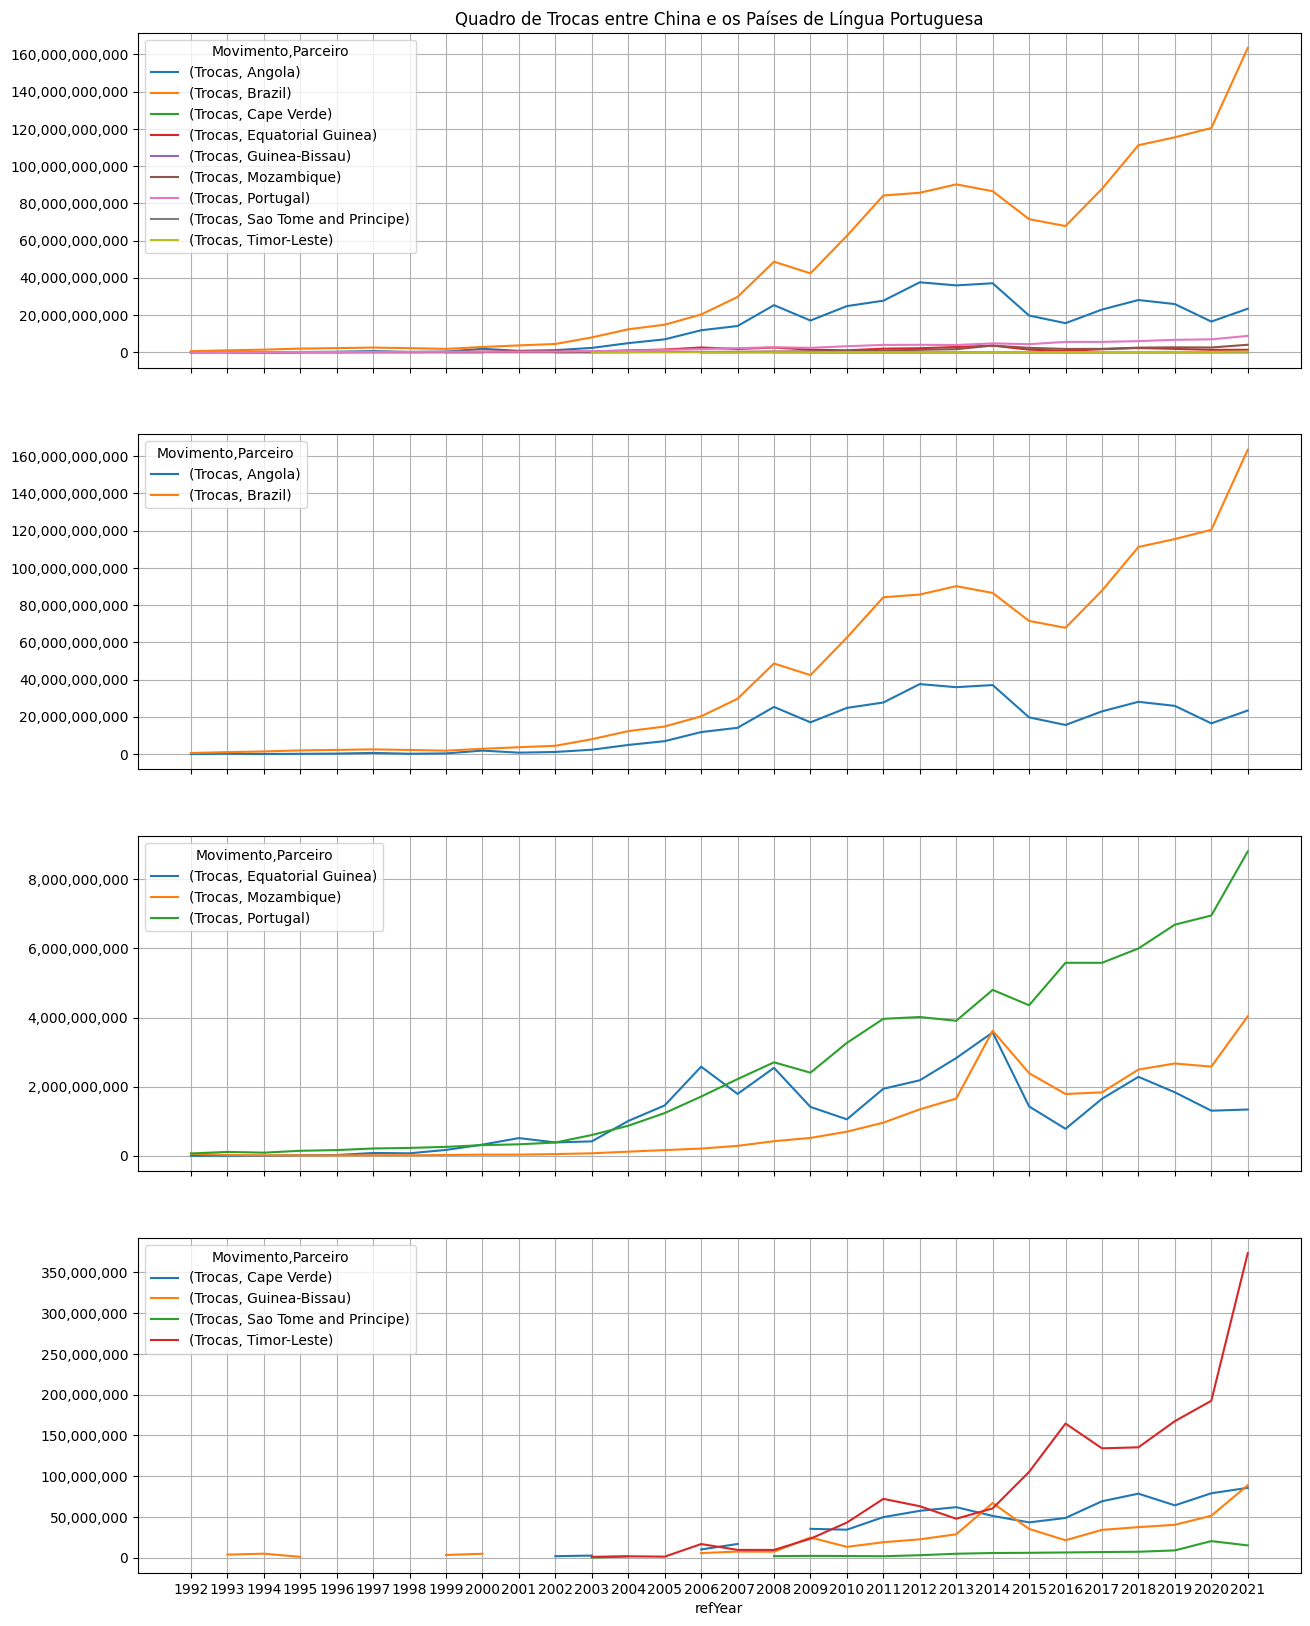

In [12]:
import matplotlib.pyplot as plt
from comtrade import COUNTRY_CODES as country

title=f"Quadro de {movimento} entre {country[m49_china]} e os Países de Língua Portuguesa"

size=(15,20)
figure,axis = plt.subplots(4,sharex=True,figsize=size, squeeze=True)
graph_data.plot.line(ax=axis[0],xticks=graph_data.index.values,title=title)

detalhe_paises = ['Angola','Brazil']
cols = [(movimento, pais) for pais in detalhe_paises]
graph_data[cols].plot.line(ax=axis[1],xticks=graph_data.index.values)

detalhe_paises = ['Equatorial Guinea','Mozambique','Portugal',]
cols = [(movimento, pais) for pais in detalhe_paises]
graph_data[cols].plot.line(ax=axis[2],xticks=graph_data.index.values)

detalhe_paises = ['Cape Verde','Guinea-Bissau','Sao Tome and Principe','Timor-Leste']
cols = [(movimento, pais) for pais in detalhe_paises]
graph_data[cols].plot.line(ax=axis[3],xticks=graph_data.index.values)

for ax in axis:
    current_values = ax.get_yticks()
    ax.set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
    ax.grid()

plt.savefig(f"{report_dir}/cn_plp_{movimento}.png")

### Gráficos importações

In [13]:
pd.options.display.float_format = '{:,.2f}'.format
movimento = 'Importações' # Trocas, Importações, Exportações
graph_data = forum_type.reset_index().pivot(index='refYear',columns=['partnerDesc'], values=[movimento])
graph_data.columns.set_names(['Movimento','Parceiro'], inplace=True)
graph_data

Movimento       Importações                                                    \
Parceiro             Angola             Brazil   Cape Verde Equatorial Guinea   
refYear                                                                         
1992          29,409,207.00     519,302,066.00          NaN         80,044.00   
1993         180,710,462.00     863,067,513.00          NaN         28,001.00   
1994          47,984,324.00   1,058,777,325.00          NaN         97,694.00   
1995         136,907,302.00   1,231,530,073.00          NaN     12,633,236.00   
1996         243,751,143.00   1,484,065,187.00          NaN     15,601,149.00   
1997         603,496,146.00   1,488,961,327.00          NaN     77,487,760.00   
1998         153,697,712.00   1,133,103,360.00          NaN     68,907,888.00   
1999         355,651,156.00     968,529,665.00          NaN    167,101,673.00   
2000       1,842,692,967.00   1,621,440,791.00          NaN    319,477,975.00   
2001         721,828,095.00   2,347,232,533.00          NaN    508,580,964.00   
2002       1,087,049,343.00   3,003,019,897.00       262.00    382,726,097.00   
2003       2,205,934,880.00   5,842,291,688.00       353.00    411,886,532.00   
2004       4,717,339,146.00   8,672,861,322.00          NaN    996,649,809.00   
2005       6,581,828,714.00   9,992,524,117.00          NaN  1,437,833,974.00   
2006      10,933,295,107.00  12,909,495,161.00       344.00  2,537,591,664.00   
2007      12,888,664,603.00  18,342,070,986.00        50.00  1,697,283,346.00   
2008      22,382,523,829.00  29,863,442,631.00          NaN  2,267,871,882.00   
2009      14,675,830,702.00  28,280,982,512.00       193.00  1,055,071,473.00   
2010      22,815,049,454.00  38,099,447,351.00    12,060.00    598,657,025.00   
2011      24,922,180,492.00  52,386,750,280.00    12,062.00  1,672,947,440.00   
2012      33,561,896,917.00  52,281,126,771.00     1,115.00  1,822,803,333.00   
2013      31,972,669,347.00  54,299,122,653.00       160.00  2,469,917,950.00   
2014      31,106,015,046.00  51,653,224,893.00     3,020.00  3,217,190,248.00   
2015      16,001,611,383.00  44,089,358,062.00    22,606.00  1,166,496,464.00   
2016      13,966,117,080.00  45,855,047,246.00    83,281.00    631,851,506.00   
2017      20,698,709,467.00  58,857,155,273.00     8,010.00  1,483,835,026.00   
2018      25,826,510,355.00  77,569,499,985.00   290,397.00  2,139,372,096.00   
2019      23,837,402,142.00  79,962,547,047.00    28,691.00  1,723,064,057.00   
2020      14,757,730,338.00  85,517,209,220.00 1,209,992.00  1,182,549,225.00   
2021      20,908,231,317.00 109,877,876,281.00 1,146,922.00  1,215,142,465.00   

Movimento                                                  \
Parceiro  Guinea-Bissau       Mozambique         Portugal   
refYear                                                     
1992                NaN    38,389,843.00    22,919,478.00   
1993       1,051,163.00     6,717,531.00    38,403,953.00   
1994         911,339.00     5,576,033.00    15,550,507.00   
1995           3,214.00     1,092,985.00    38,633,592.00   
1996                NaN       198,206.00    30,658,597.00   
1997       1,038,609.00       729,796.00    44,666,900.00   
1998                NaN       427,301.00    26,952,180.00   
1999         195,510.00     3,299,368.00    38,288,657.00   
2000         181,700.00     8,777,791.00    46,949,131.00   
2001                NaN    11,193,891.00    71,460,151.00   
2002                NaN    22,578,190.00    82,705,528.00   
2003                NaN    26,591,793.00   194,613,740.00   
2004          29,251.00    44,286,108.00   280,896,511.00   
2005                NaN    73,527,324.00   323,834,266.00   
2006              64.00    79,772,228.00   353,809,128.00   
2007         172,994.00   124,248,069.00   384,642,280.00   
2008       1,242,562.00   125,882,374.00   387,489,834.00   
2009       1,617,183.00   177,554,369.00   480,929,852.00   
2010       3,862,870.00   201,077,529.00   75

/var/folders/sx/x6pyh9097n98mlz29_6njdj00000gn/T/ipykernel_82221/593253419.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0f}'.format(x) for x in current_values])


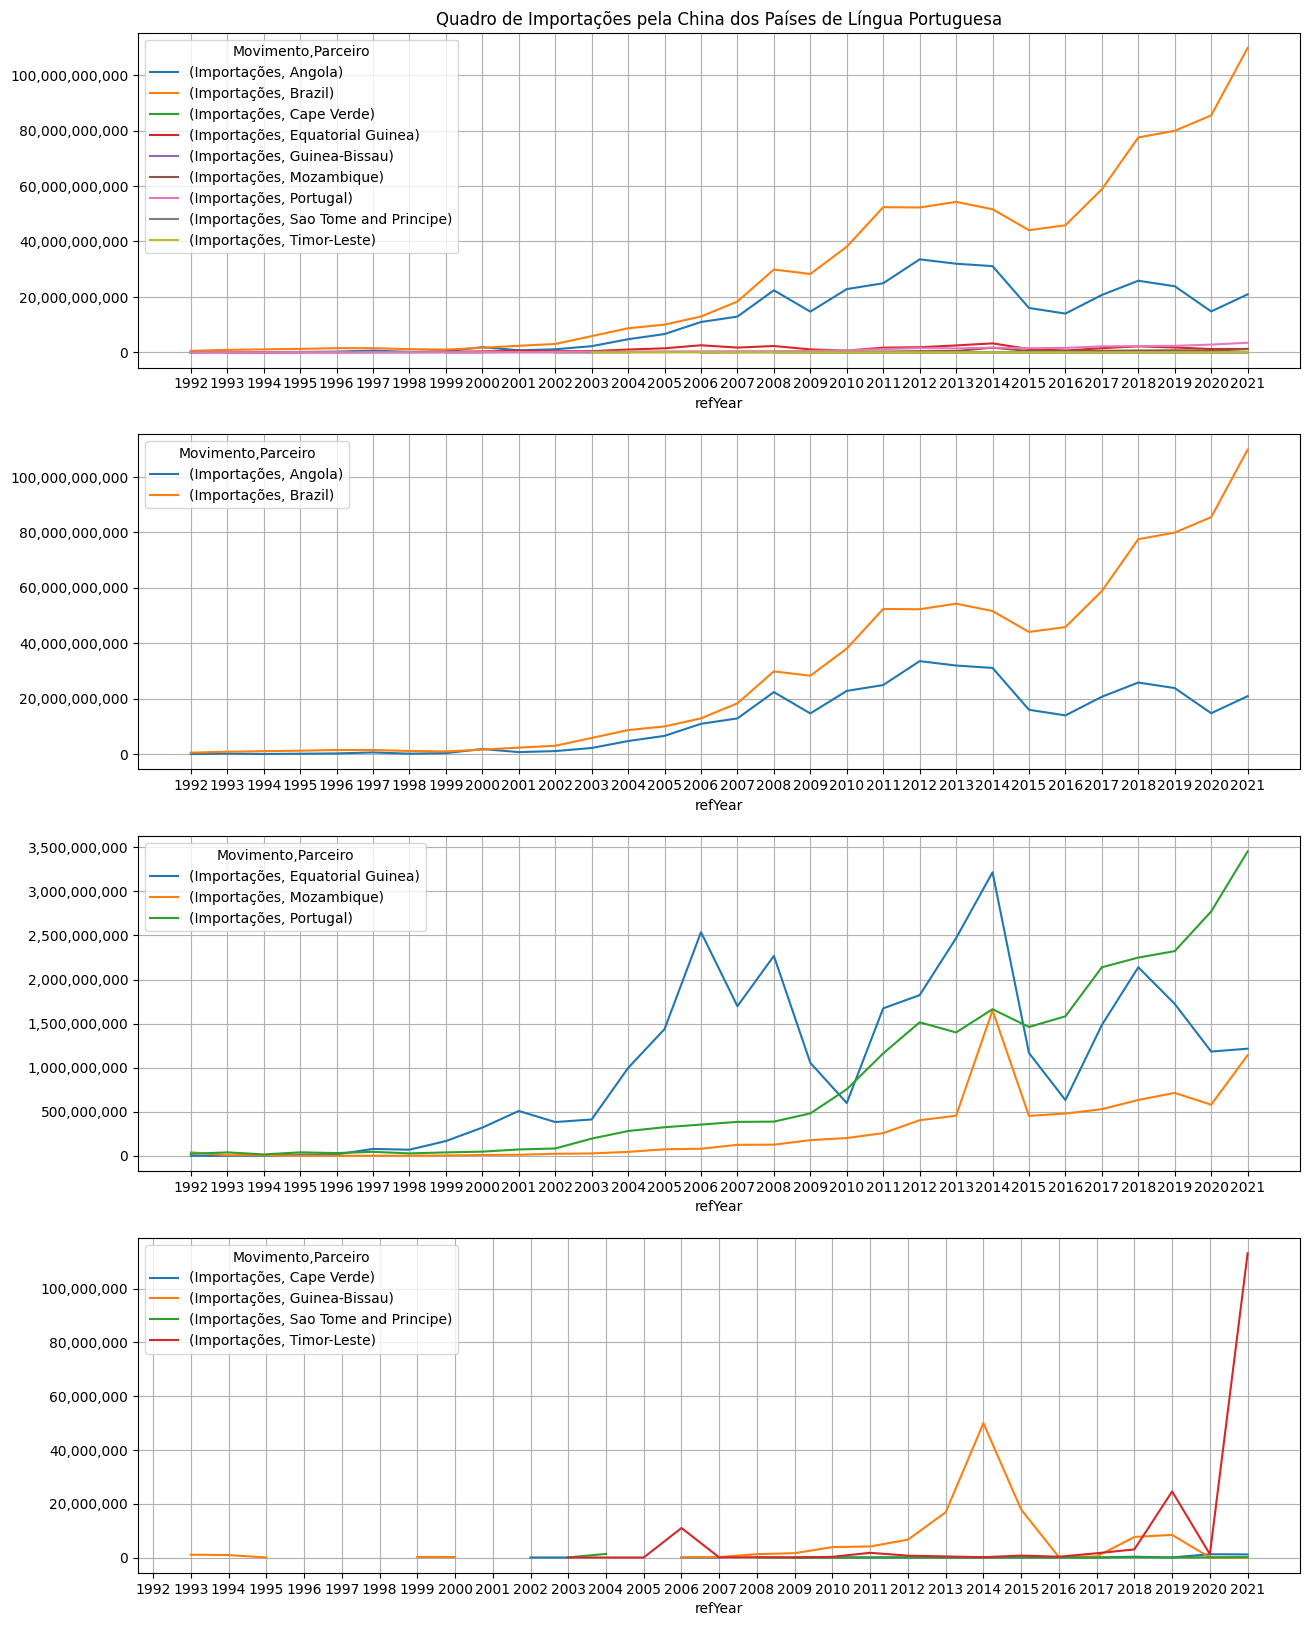

In [14]:
from comtrade import COUNTRY_CODES as country

title=f"Quadro de {movimento} pela {country[m49_china]} dos Países de Língua Portuguesa"

size=(15,20)
figure,axis = plt.subplots(4,sharex=False,figsize=size, squeeze=True)
graph_data.plot.line(ax=axis[0],xticks=graph_data.index.values,title=title)

detalhe_paises = ['Angola','Brazil']
cols = [(movimento, pais) for pais in detalhe_paises]
graph_data[cols].plot.line(ax=axis[1],xticks=graph_data.index.values)

detalhe_paises = ['Equatorial Guinea','Mozambique','Portugal',]
cols = [(movimento, pais) for pais in detalhe_paises]
graph_data[cols].plot.line(ax=axis[2],xticks=graph_data.index.values)

detalhe_paises = ['Cape Verde','Guinea-Bissau','Sao Tome and Principe','Timor-Leste']
cols = [(movimento, pais) for pais in detalhe_paises]
graph_data[cols].plot.line(ax=axis[3],xticks=graph_data.index.values)

for ax in axis:
    current_values = ax.get_yticks()
    ax.set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
    ax.grid()

plt.savefig(f"{report_dir}/cn_plp_{movimento}.png")

### Gráficos exportações

In [15]:
pd.options.display.float_format = '{:,.2f}'.format
movimento = 'Exportações' # Trocas, Importações, Exportações
graph_data = forum_type.reset_index().pivot(index='refYear',columns=['partnerDesc'], values=[movimento])
graph_data.columns.set_names(['Movimento','Parceiro'], inplace=True)
graph_data

Movimento      Exportações                                                    \
Parceiro            Angola            Brazil    Cape Verde Equatorial Guinea   
refYear                                                                        
1992          8,472,850.00     64,751,735.00    161,485.00        180,825.00   
1993         11,206,948.00    192,166,216.00    754,935.00        635,394.00   
1994         12,482,005.00    362,390,910.00    424,394.00        584,829.00   
1995         21,159,336.00    759,058,693.00    380,342.00      2,330,370.00   
1996         28,533,705.00    762,930,545.00    274,927.00      5,970,663.00   
1997         29,128,511.00  1,044,389,298.00    405,394.00      3,335,113.00   
1998         36,653,028.00  1,085,363,968.00  1,960,845.00      2,937,185.00   
1999         16,363,697.00    876,002,206.00  3,141,087.00      2,497,962.00   
2000         33,735,509.00  1,223,545,495.00  5,178,211.00      3,549,061.00   
2001         45,721,834.00  1,350,925,018.00  2,212,932.00      3,354,587.00   
2002         61,310,901.00  1,466,382,340.00  1,839,369.00      3,287,681.00   
2003        145,791,215.00  2,143,255,914.00  2,596,097.00      5,048,022.00   
2004        193,517,905.00  3,674,104,212.00  2,746,211.00     10,124,623.00   
2005        372,793,946.00  4,827,209,396.00  5,187,788.00     18,801,431.00   
2006        894,185,633.00  7,380,105,731.00 10,094,090.00     41,107,988.00   
2007      1,234,518,651.00 11,398,472,406.00 16,826,488.00     92,790,802.00   
2008      2,942,469,756.00 18,807,457,292.00 14,953,954.00    277,390,904.00   
2009      2,385,960,008.00 14,118,518,263.00 35,405,032.00    358,423,820.00   
2010      2,003,872,576.00 24,460,651,866.00 34,335,093.00    456,241,241.00   
2011      2,784,153,366.00 31,836,677,325.00 49,751,685.00    266,317,114.00   
2012      4,039,171,270.00 33,413,633,342.00 57,490,473.00    361,434,154.00   
2013      3,964,058,933.00 35,895,471,244.00 61,996,094.00    357,517,241.00   
2014      5,974,996,819.00 34,890,134,489.00 51,223,437.00    352,515,328.00   
2015      3,717,145,883.00 27,412,225,426.00 43,300,195.00    261,389,919.00   
2016      1,680,398,624.00 21,976,152,765.00 48,671,438.00    148,253,831.00   
2017      2,257,453,225.00 28,950,538,235.00 69,239,870.00    166,217,956.00   
2018      2,253,137,107.00 33,665,139,187.00 78,265,751.00    145,146,401.00   
2019      2,055,727,417.00 35,539,063,912.00 64,166,991.00    113,204,451.00   
2020      1,748,092,204.00 34,953,227,525.00 77,836,679.00    122,120,216.00   
2021      2,491,545,681.00 53,612,224,393.00 84,537,739.00    123,984,094.00   

Movimento                                                  \
Parceiro  Guinea-Bissau       Mozambique         Portugal   
refYear                                                     
1992       2,401,586.00    20,729,009.00    43,992,562.00   
1993       2,716,341.00    16,548,204.00    73,928,694.00   
1994       4,002,964.00     6,518,220.00    74,517,509.00   
1995       1,090,892.00    11,523,079.00   106,053,862.00   
1996         462,599.00    11,235,225.00   133,797,930.00   
1997         722,255.00    15,941,226.00   166,149,804.00   
1998       1,452,681.00    13,333,985.00   200,589,600.00   
1999       3,181,137.00    18,931,038.00   219,943,236.00   
2000       4,621,401.00    24,706,053.00   260,823,590.00   
2001       8,299,380.00    22,041,054.00   260,568,014.00   
2002       4,503,979.00    25,931,947.00   300,879,648.00   
2003      12,350,232.00    45,028,314.00   406,256,461.00   
2004       5,994,304.00    75,154,316.00   588,259,140.00   
2005       5,793,889.00    91,477,874.00   911,952,506.00   
2006       5,677,056.00   127,940,363.00 1,359,664,205.00   
2007       7,308,823.00   163,552,940.00 1,834,752,144.00   
2008       6,146,998.00   295,994,949.00 2,317,102,263.00   
2009      23,193,644.00   339,133,810.00 1,923,516,206.00   
2010       9,433,700.00   496,391,036.00 2,513,317,692.00   
2011      14,850,

/var/folders/sx/x6pyh9097n98mlz29_6njdj00000gn/T/ipykernel_82221/1921030421.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0f}'.format(x) for x in current_values])


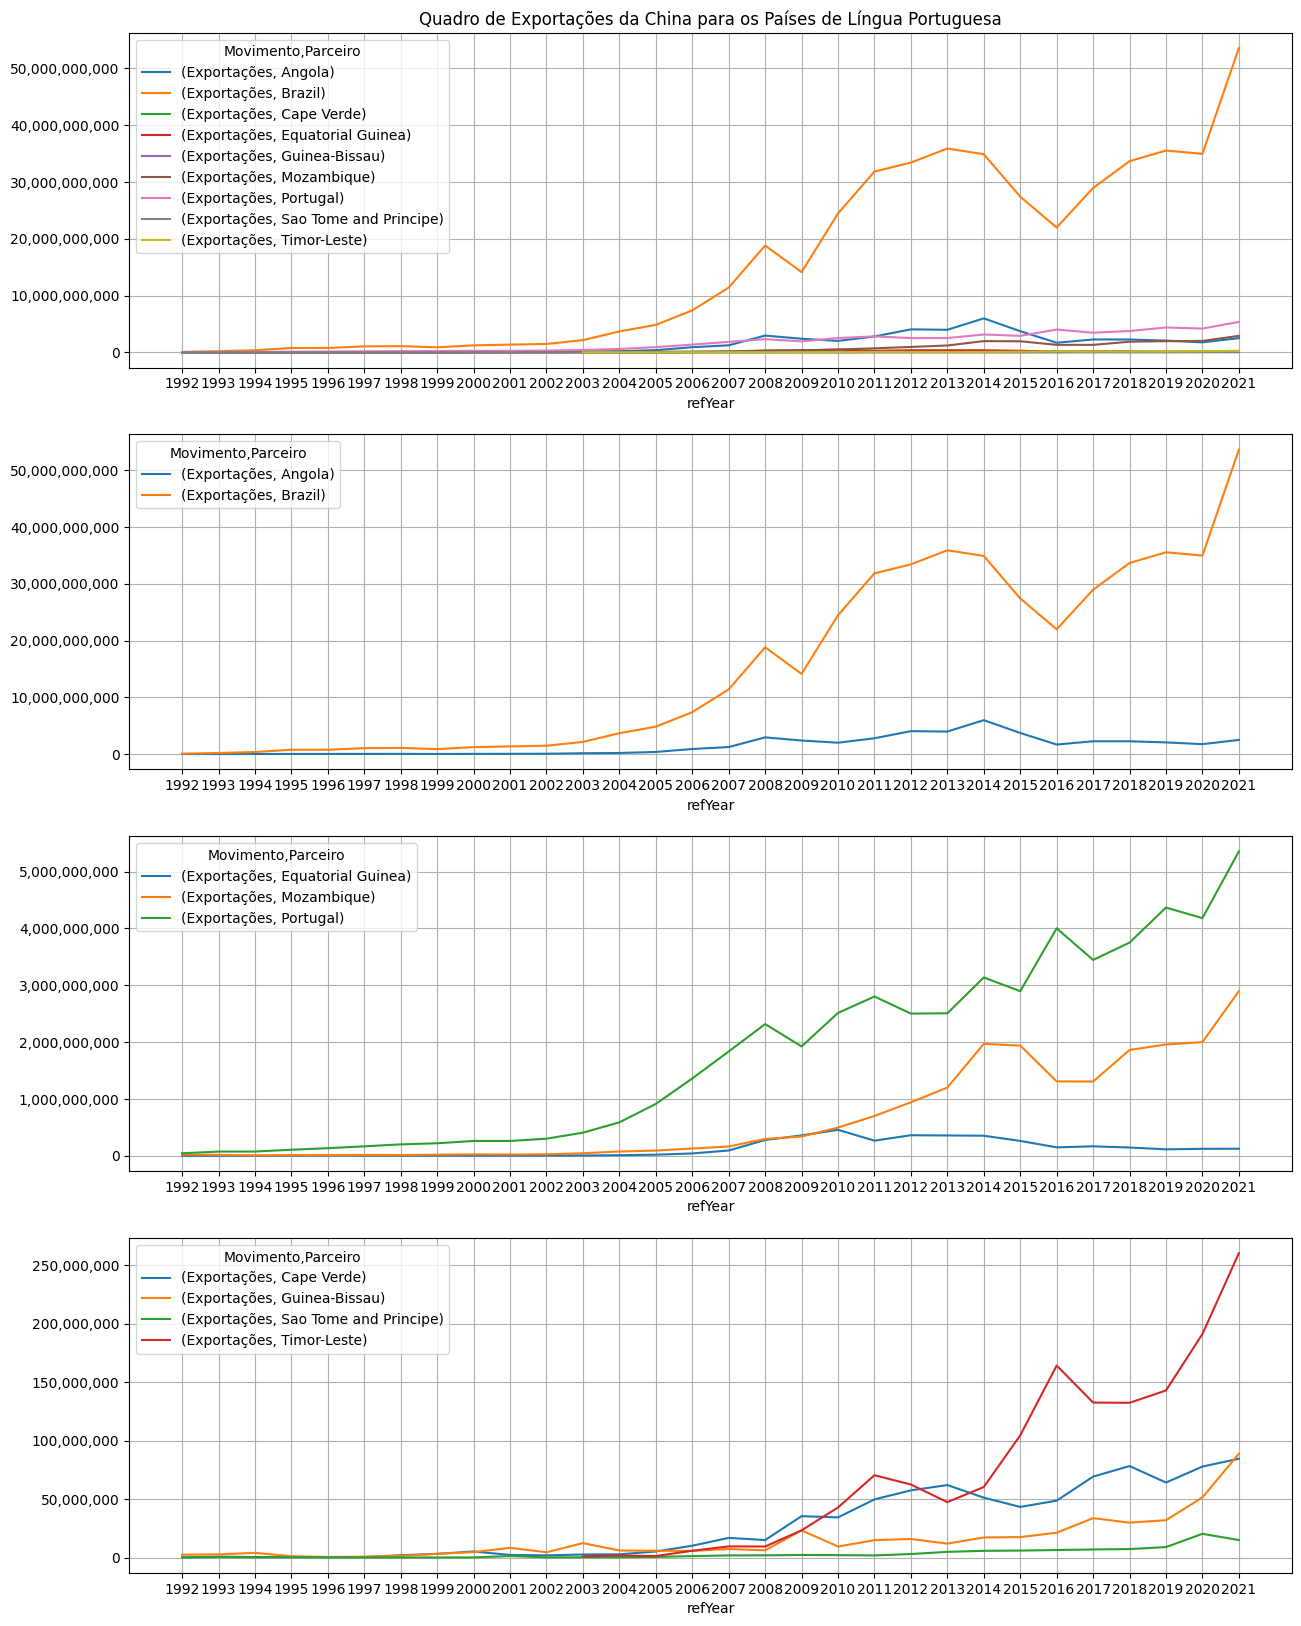

In [16]:
from comtrade import COUNTRY_CODES as country

title=f"Quadro de {movimento} da {country[m49_china]} para os Países de Língua Portuguesa"

size=(15,20)
figure,axis = plt.subplots(4,sharex=False,figsize=size, squeeze=True)
graph_data.plot.line(ax=axis[0],xticks=graph_data.index.values,title=title)

detalhe_paises = ['Angola','Brazil']
cols = [(movimento, pais) for pais in detalhe_paises]
graph_data[cols].plot.line(ax=axis[1],xticks=graph_data.index.values)

detalhe_paises = ['Equatorial Guinea','Mozambique','Portugal',]
cols = [(movimento, pais) for pais in detalhe_paises]
graph_data[cols].plot.line(ax=axis[2],xticks=graph_data.index.values)

detalhe_paises = ['Cape Verde','Guinea-Bissau','Sao Tome and Principe','Timor-Leste']
cols = [(movimento, pais) for pais in detalhe_paises]
graph_data[cols].plot.line(ax=axis[3],xticks=graph_data.index.values)

for ax in axis:
    current_values = ax.get_yticks()
    ax.set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
    ax.grid()

plt.savefig(f"{report_dir}/cn_plp_{movimento}.png")

### Gráficos saldo (China: exportações-importações)

In [17]:
pd.options.display.float_format = '{:,.2f}'.format
movimento = 'Saldo' # Trocas, Importações, Exportações
graph_data = forum_type.reset_index().pivot(index='refYear',columns=['partnerDesc'], values=[movimento])
graph_data.columns.set_names(['Movimento','Parceiro'], inplace=True)
graph_data

Movimento              Saldo                                   \
Parceiro              Angola             Brazil    Cape Verde   
refYear                                                         
1992          -20,936,357.00    -454,550,331.00           NaN   
1993         -169,503,514.00    -670,901,297.00           NaN   
1994          -35,502,319.00    -696,386,415.00           NaN   
1995         -115,747,966.00    -472,471,380.00           NaN   
1996         -215,217,438.00    -721,134,642.00           NaN   
1997         -574,367,635.00    -444,572,029.00           NaN   
1998         -117,044,684.00     -47,739,392.00           NaN   
1999         -339,287,459.00     -92,527,459.00           NaN   
2000       -1,808,957,458.00    -397,895,296.00           NaN   
2001         -676,106,261.00    -996,307,515.00           NaN   
2002       -1,025,738,442.00  -1,536,637,557.00  1,839,107.00   
2003       -2,060,143,665.00  -3,699,035,774.00  2,595,744.00   
2004       -4,523,821,241.00  -4,998,757,110.00           NaN   
2005       -6,209,034,768.00  -5,165,314,721.00           NaN   
2006      -10,039,109,474.00  -5,529,389,430.00 10,093,746.00   
2007      -11,654,145,952.00  -6,943,598,580.00 16,826,438.00   
2008      -19,440,054,073.00 -11,055,985,339.00           NaN   
2009      -12,289,870,694.00 -14,162,464,249.00 35,404,839.00   
2010      -20,811,176,878.00 -13,638,795,485.00 34,323,033.00   
2011      -22,138,027,126.00 -20,550,072,955.00 49,739,623.00   
2012      -29,522,725,647.00 -18,867,493,429.00 57,489,358.00   
2013      -28,008,610,414.00 -18,403,651,409.00 61,995,934.00   
2014      -25,131,018,227.00 -16,763,090,404.00 51,220,417.00   
2015      -12,284,465,500.00 -16,677,132,636.00 43,277,589.00   
2016      -12,285,718,456.00 -23,878,894,481.00 48,588,157.00   
2017      -18,441,256,242.00 -29,906,617,038.00 69,231,860.00   
2018      -23,573,373,248.00 -43,904,360,798.00 77,975,354.00   
2019      -21,781,674,725.00 -44,423,483,135.00 64,138,300.00   
2020      -13,009,638,134.00 -50,563,981,695.00 76,626,687.00   
2021      -18,416,685,636.00 -56,265,651,888.00 83,390,817.00   

Movimento                                                                     \
Parceiro  Equatorial Guinea  Guinea-Bissau       Mozambique         Portugal   
refYear                                                                        
1992             100,781.00            NaN   -17,660,834.00    21,073,084.00   
1993             607,393.00   1,665,178.00     9,830,673.00    35,524,741.00   
1994             487,135.00   3,091,625.00       942,187.00    58,967,002.00   
1995         -10,302,866.00   1,087,678.00    10,430,094.00    67,420,270.00   
1996          -9,630,486.00            NaN    11,037,019.00   103,139,333.00   
1997         -74,152,647.00    -316,354.00    15,211,430.00   121,482,904.00   
1998         -65,970,703.00            NaN    12,906,684.00   173,637,420.00   
1999        -164,603,711.00   2,985,627.00    15,631,670.00   181,654,579.00   
2000        -315,928,914.00   4,439,701.00    15,928,262.00   213,874,459.00   
2001        -505,226,377.00            NaN    10,847,163.00   189,107,863.00   
2002        -379,438,416.00            NaN     3,353,757.00   218,174,120.00   
2003        -406,838,510.00            NaN    18,436,521.00   211,642,721.00   
2004        -986,525,186.00   5,965,053.00    30,868,208.00   307,362,629.00   
2005      -1,419,032,543.00            NaN    17,950,550.00   588,118,240.00   
2006      -2,496,483,676.00   5,676,992.00    48,168,135.00 1,005,855,077.00   
2007      -1,604,492,544.00   7,135,829.00    39,304,871.00 1,450,109,864.00   
2008      -1,990,480,978.00   4,904,436.00   170,112,575.00 1,929,612,429.00   
2009        -696,647,653.00  21,576,461.00   161,579,441.00 1,442,586,354.00   
2010        -142,415,784.00   5,570,830.00   295,313,507.00 1,758,891,674.00   
2011      -1,406,630,326.00  10,738,246.00   443,005,827.00 1,639,369,807.00   
2012      -1,4

/var/folders/sx/x6pyh9097n98mlz29_6njdj00000gn/T/ipykernel_82221/2146500004.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0f}'.format(x) for x in current_values])


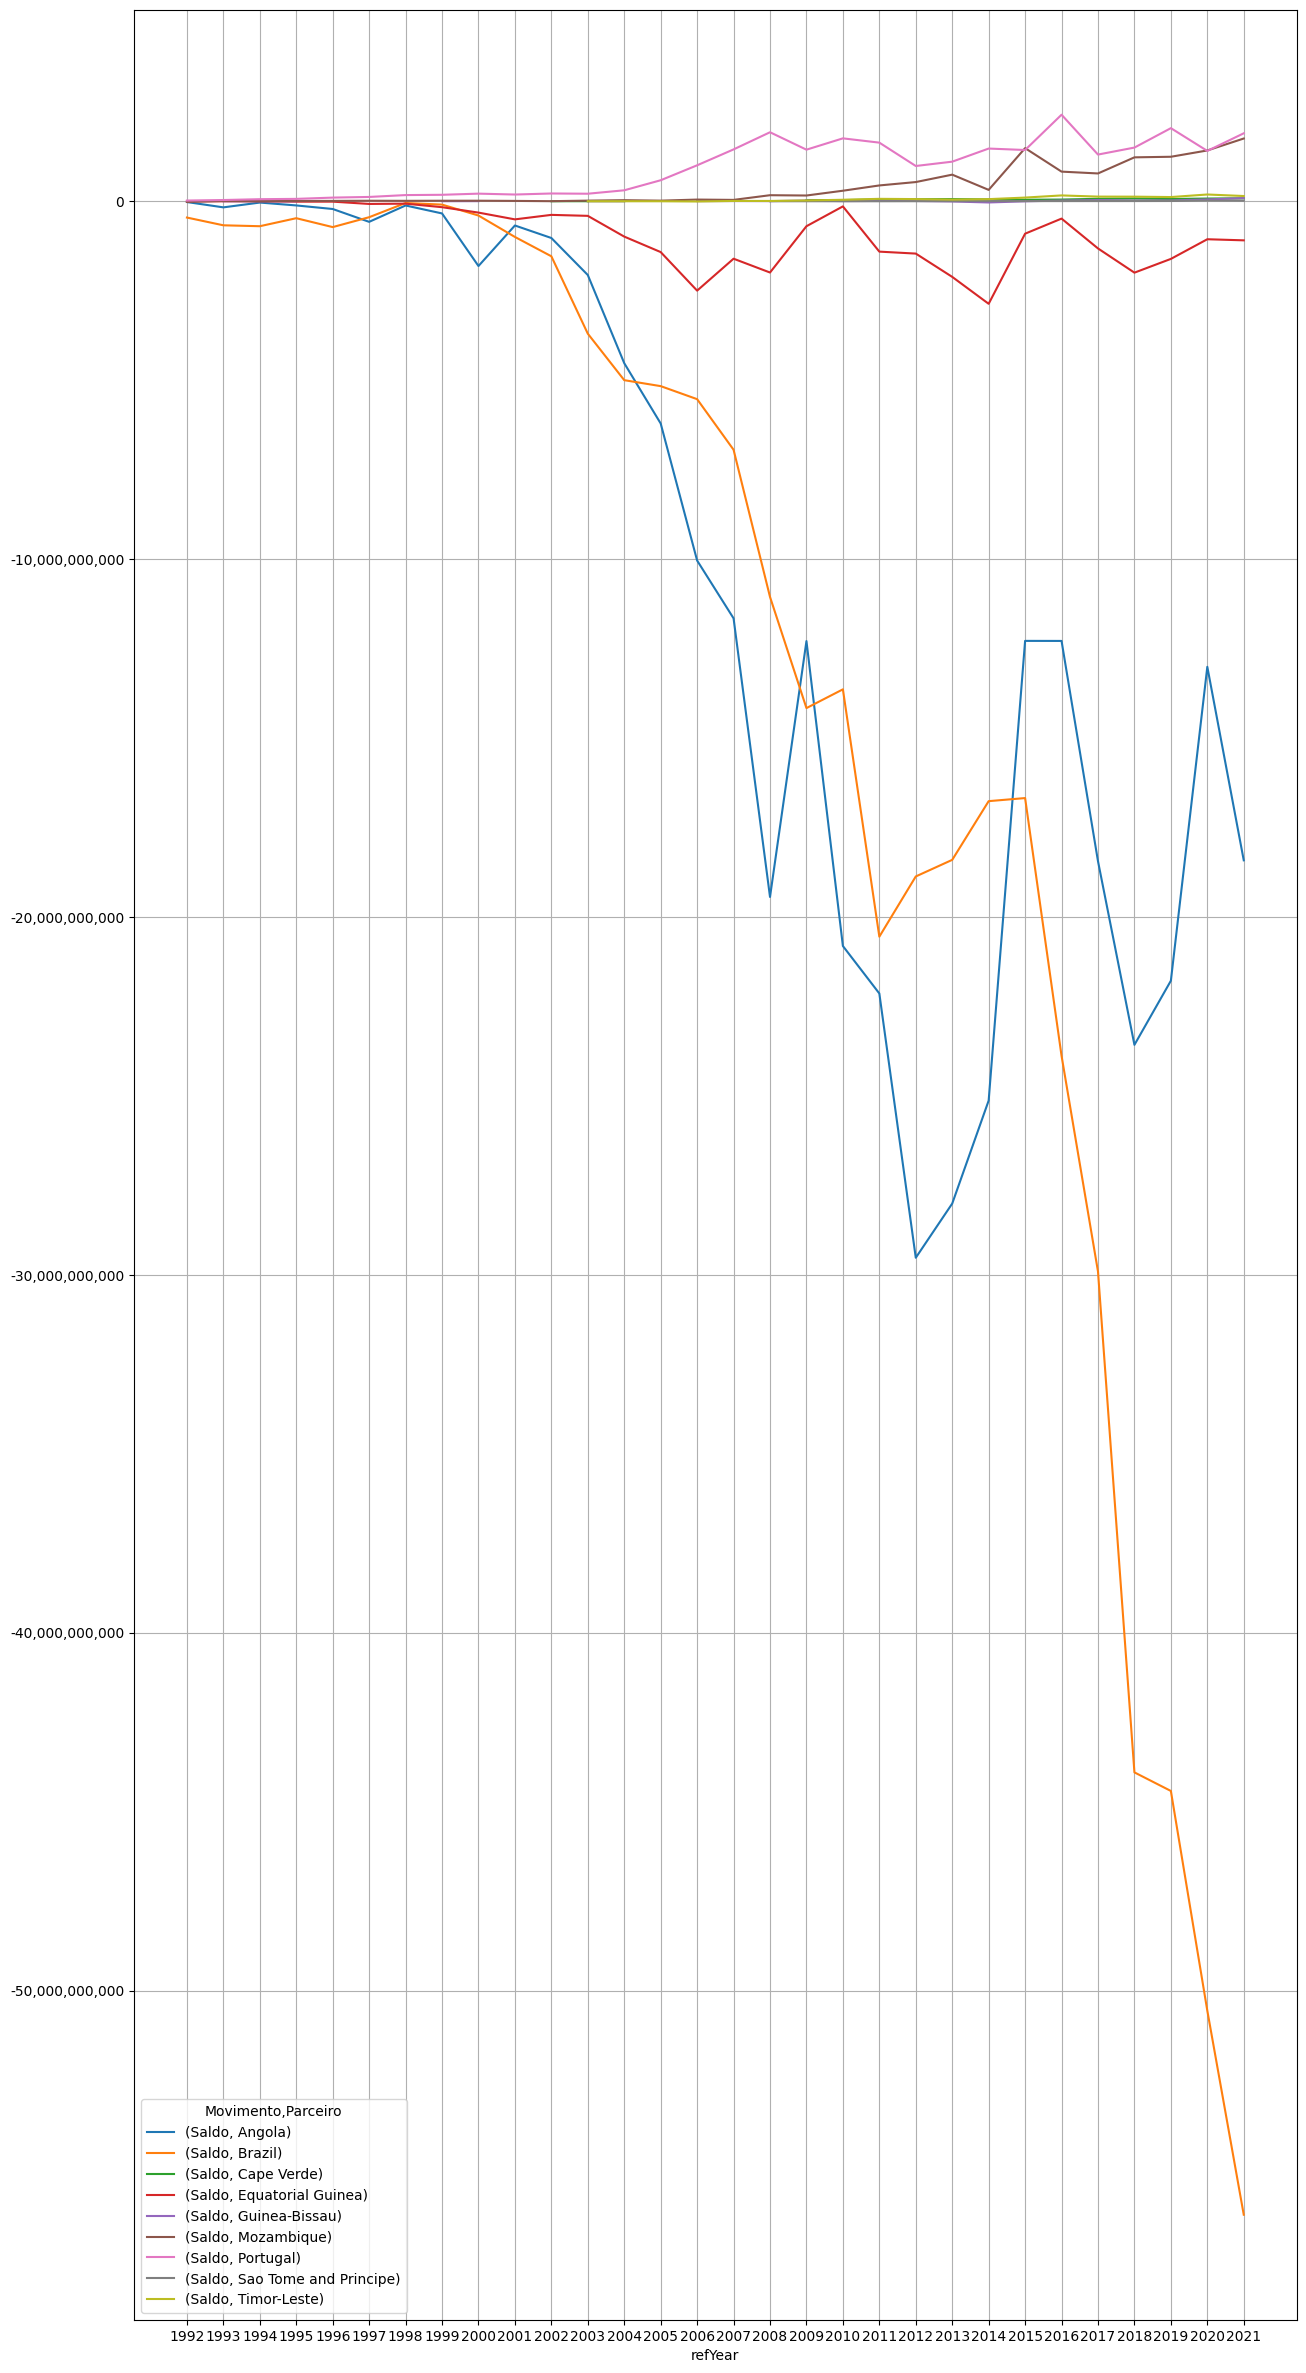

In [18]:
import matplotlib.pyplot as plt
ax = graph_data.plot.line(figsize=(15,30),xticks=graph_data.index.values)

current_values = ax.get_yticks()
ax.set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
ax.grid()
plt.savefig(f"{report_dir}/cn_plp_{movimento}.png")

In [19]:
import datetime
# print the current date and time


print("Current date and time: ", datetime.datetime.now())

Current date and time:  2022-12-07 15:17:01.725145
